### Imports

In [1]:
import os
import sys
sys.path.append('../scripts')

import sentinel, evalscripts
import matplotlib.pyplot as plt
import numpy as np
from geopy.distance import distance
from geopy.point import Point
import yaml

from sentinelhub import (
    CRS,
    BBox,
    bbox_to_dimensions,
    SHConfig
)
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Creditential

In [2]:
# Fetch credentials for modis
with open("../config.yaml") as file:
    credentials = yaml.safe_load(file)
user = credentials["sentinelhub"]["API_USER"]
password = credentials["sentinelhub"]["API_PASSWORD"]

config = SHConfig(
    sh_client_id = user,
    sh_client_secret = password
)

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")


### Setup

In [3]:
# Bounding box coordinates (you can use http://bboxfinder.com/ to find the coordinates of your desired bounding box)
#(-124.45976373769807,48.62786844842075,-115.12341739786068,53.51536369187604)
lon_min = -124.45976373769807
lat_min = 48.62786844842075
lon_max = -115.12341739786068
lat_max = 53.51536369187604

#Desired spacing in kilometers between each image
spacing_km = 100

#Desired resolution of each image
resolution = 300

start_date = "2021-06-29"
end_date = "2021-08-30"

sentinel_request_dir = "../data/sentinel/request"
sentinel_tiff_dir = "../data/sentinel/tiff"
sentinel_merge_dir = "../data/sentinel/merge"

### Get points and bbox for the selected area

In [4]:
points, max_points_in_line, num_lines, points_per_line = sentinel.generate_grid_within_box(lat_min, lon_min, lat_max, lon_max, spacing_km)
points = [(y, x) for x, y in points]
    
aoi_bbox_list = []
for point in points:
    aoi_coords_wgs842 = sentinel.boundingBox(point[0],point[1],spacing_km/2)
    aoi_bbox_list.append(BBox(bbox=aoi_coords_wgs842, crs=CRS.WGS84))

aoi_size = bbox_to_dimensions(aoi_bbox_list[1], resolution=resolution)

## Print informations

In [5]:
print("Number of points per line: ", max_points_in_line)
print("Number of lines: ", num_lines)
print("Total number of points generated: ", len(points))
print("List of number of points per line: ", points_per_line)
print(f"Image shape at {resolution} m resolution: {aoi_size} pixels")

Number of points per line:  7
Number of lines:  6
Total number of points generated:  42
List of number of points per line:  [7, 7, 7, 7, 7, 7]
Image shape at 300 m resolution: (334, 334) pixels


## Get data

In [6]:
#You can chose  your evalscript here between evalscript_ndvi and evalscript_CloudFree_Composite:
evalscript = evalscripts.evalscript_CloudFree_Composite

ndvi_img_list = []
for aoi_bbox in aoi_bbox_list:
    ndvi_img = sentinel.get_ndvi_img(aoi_bbox,aoi_size,sentinel_request_dir,start_date,end_date,evalscript,config)
    ndvi_img_list.append(ndvi_img)

### Concatenation in a tiff file

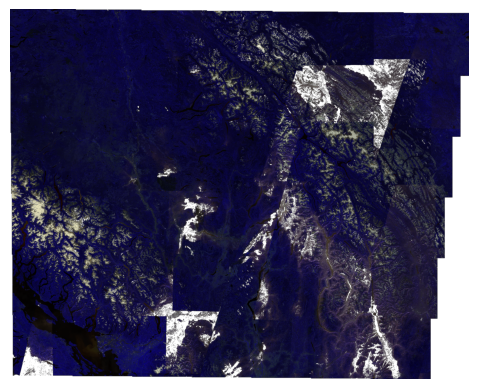

In [7]:
sentinel.concatenate_tiff_images(sentinel_request_dir,sentinel_tiff_dir, sentinel_merge_dir)
 